In [42]:
import json
import re
import os
import pandas as pd
import time

import sqlvalidator

from datasets import load_dataset
from langdetect import detect


def translate(source, target_lang='en'):
    import googletrans as gt
    return gt.translate(source, target_lang)

CACHE_DIR = "../cache"
SPIDER_DATASET_DIR = "../dataset/spider/"

In [2]:
def find_primary_keys_MYSQL_like(db_name, spider_primary):
    df = spider_primary[spider_primary['Database name'] == db_name]
    output = "["
    for index, row in df.iterrows():
        output += row['Table Name'] + '.' + row['Primary Key'] +','
    output = output[:-1]
    output += "]\n"
    return output
def creating_schema(DATASET_JSON):
    schema_df = pd.read_json(DATASET_JSON)
    schema_df = schema_df.drop(['column_names','table_names'], axis=1)
    schema = []
    f_keys = []
    p_keys = []
    for index, row in schema_df.iterrows():
        tables = row['table_names_original']
        col_names = row['column_names_original']
        col_types = row['column_types']
        foreign_keys = row['foreign_keys']
        primary_keys = row['primary_keys']
        for col, col_type in zip(col_names, col_types):
            index, col_name = col
            if index == -1:
                for table in tables:
                    schema.append([row['db_id'], table, '*', 'text'])
            else:
                schema.append([row['db_id'], tables[index], col_name, col_type])
        for primary_key in primary_keys:
            index, column = col_names[primary_key]
            p_keys.append([row['db_id'], tables[index], column])
        for foreign_key in foreign_keys:
            first, second = foreign_key
            first_index, first_column = col_names[first]
            second_index, second_column = col_names[second]
            f_keys.append([row['db_id'], tables[first_index], tables[second_index], first_column, second_column])
    spider_schema = pd.DataFrame(schema, columns=['Database name', ' Table Name', ' Field Name', ' Type'])
    spider_primary = pd.DataFrame(p_keys, columns=['Database name', 'Table Name', 'Primary Key'])
    spider_foreign = pd.DataFrame(
        f_keys,
        columns=[
            'Database name', 'First Table Name', 'Second Table Name', 'First Table Foreign Key',
            'Second Table Foreign Key'
        ]
    )
    return spider_schema,spider_primary,spider_foreign

In [3]:
def convert_type_to_sql_type(type):
    if type == 'text':
        return 'VARCHAR'
    elif type == 'integer' or type == 'number' or type == 'int':
        return 'INTEGER'
    elif type == 'time':
        return 'DATETIME'
    elif type == 'boolean':
        return 'BOOLEAN'
    elif type == 'real' or type == 'float' or type == 'double':
        return 'FLOAT'
    elif type == 'others':
        return 'BOOLEAN'
    else:
        return 'VARCHAR'

def get_context_with_db_name(db_name, spider_schema, spider_primary, spider_foreign):
    # find all tables related to db_name
    df = spider_schema[spider_schema['Database name'] == db_name]
    df = df.groupby(' Table Name')
    tables = []
    for name, group in df:
        table = {}
        table['name'] = name
        table['columns'] = []
        for index, row in group.iterrows():
            table['columns'].append((row[" Field Name"], row[" Type"]))
        tables.append(table)
        
    # for each table, create the "CREATE TABLE" statement and append it to context
    statements = []
    for table in tables:
        statement = "CREATE TABLE " + table['name'] + " ("
        for idx, column in enumerate(table['columns']):
            col_name = column[0]
            col_type = column[1]
            if col_name == '*':
                continue
            if ' ' in col_name:
                col_name = '"' + col_name + '"'
            
            
            statement += col_name + " " + col_type
            if idx != len(table['columns']) - 1:
                statement += ", "
        statement = statement + ")"
        statements.append(statement)
    
    # print("; ".join(statements))
    return "; ".join(statements)

In [4]:
def preprocess_text(text):
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\(\s+', '(', text)
    text = re.sub(r'\s+\)', ')', text)
    text = text.replace(' ,  ', ', ')
    text = text.replace(' .  ', '. ')
    text = text.replace(' ,' , ',')
    return text

In [22]:
spider_schema,spider_primary,spider_foreign = creating_schema(
    os.path.join(SPIDER_DATASET_DIR, 'tables.json')
)

In [23]:
train_spider = pd.read_json(os.path.join(SPIDER_DATASET_DIR, 'train_spider.json'))
print(len(train_spider))
train_spider.head()

7000


,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'from': {'table_units': [['table_unit', 1]], ..."
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'from': {'table_units': [['table_unit', 1]], ..."
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'from': {'table_units': [['table_unit', 0]], ..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","{'from': {'table_units': [['table_unit', 0]], ..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","{'from': {'table_units': [['table_unit', 0]], ..."


In [24]:
train_others = pd.read_json(os.path.join(SPIDER_DATASET_DIR, 'train_others.json'))
print(len(train_others))
train_others.head()

1659


,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,geo,SELECT city_name FROM city WHERE population =...,"[SELECT, city_name, FROM, city, WHERE, populat...","[select, city_name, from, city, where, populat...",what is the biggest city in wyoming,"[what, is, the, biggest, city, in, wyoming]","{'from': {'table_units': [['table_unit', 1]], ..."
1,geo,SELECT city_name FROM city WHERE population =...,"[SELECT, city_name, FROM, city, WHERE, populat...","[select, city_name, from, city, where, populat...",what wyoming city has the largest population,"[what, wyoming, city, has, the, largest, popul...","{'from': {'table_units': [['table_unit', 1]], ..."
2,geo,SELECT city_name FROM city WHERE population =...,"[SELECT, city_name, FROM, city, WHERE, populat...","[select, city_name, from, city, where, populat...",what is the largest city in wyoming,"[what, is, the, largest, city, in, wyoming]","{'from': {'table_units': [['table_unit', 1]], ..."
3,geo,SELECT city_name FROM city WHERE population =...,"[SELECT, city_name, FROM, city, WHERE, populat...","[select, city_name, from, city, where, populat...",where is the most populated area of wyoming,"[where, is, the, most, populated, area, of, wy...","{'from': {'table_units': [['table_unit', 1]], ..."
4,geo,SELECT city_name FROM city WHERE population =...,"[SELECT, city_name, FROM, city, WHERE, populat...","[select, city_name, from, city, where, populat...",which city in wyoming has the largest population,"[which, city, in, wyoming, has, the, largest, ...","{'from': {'table_units': [['table_unit', 1]], ..."


In [25]:
get_context_with_db_name('geo', spider_schema, spider_primary, spider_foreign)

'CREATE TABLE border_info (state_name text, border text); CREATE TABLE city (city_name text, population number, country_name text, state_name text); CREATE TABLE highlow (state_name text, highest_elevation text, lowest_point text, highest_point text, lowest_elevation text); CREATE TABLE lake (lake_name text, area number, country_name text, state_name text); CREATE TABLE mountain (mountain_name text, mountain_altitude number, country_name text, state_name text); CREATE TABLE river (river_name text, length number, country_name text, traverse text); CREATE TABLE state (state_name text, population number, area number, country_name text, capital text, density number)'

In [28]:
processed_dataset = {'train': []}
for database in [train_spider, train_others]:
    for idx, sample in database.iterrows():
        db_id = sample['db_id']
        answer = preprocess_text(sample['query'])
        context = get_context_with_db_name(db_id, spider_schema, spider_primary, spider_foreign)
        question = preprocess_text(sample['question'])
        processed_dataset['train'].append({
            'context': context,
            'question': question,
            'answer': answer
        })


In [36]:
dev_spider = pd.read_json(os.path.join(SPIDER_DATASET_DIR, 'dev.json'))
processed_dataset['dev'] = []
for idx, sample in dev_spider.iterrows():
    db_id = sample['db_id']
    answer = preprocess_text(sample['query'])
    context = get_context_with_db_name(db_id, spider_schema, spider_primary, spider_foreign)
    question = preprocess_text(sample['question'])
    processed_dataset['dev'].append({
        'context': context,
        'question': question,
        'answer': answer
    })

In [37]:
# save each subset to json file
JSON_DIR = "../dataset/SpiderInstruct_raw"
os.makedirs(JSON_DIR, exist_ok=True)
for subset in processed_dataset:
    with open(f"{JSON_DIR}/{subset}.jsonl", 'w', encoding='utf-8') as f:
        for sample in processed_dataset[subset]:
            json.dump(sample, f, ensure_ascii=False)
            f.write('\n')

In [39]:
import os
import tarfile

def makr_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
        
for subset in processed_dataset:
    makr_tarfile(
        os.path.join(JSON_DIR, f"{subset}.tar.gz"),
        os.path.join(JSON_DIR, f"{subset}.jsonl")
    )

## Load instruct spider from huggingface

In [43]:
from datasets import load_dataset

CACHE_DIR = "../cache"

dataset = load_dataset('tmnam20/SpiderInstruct', None, cache_dir=CACHE_DIR)
dataset

No config specified, defaulting to: spider_instruct/default
Found cached dataset spider_instruct (/Users/minhnam/Desktop/text2sql-llama/notebooks/../cache/tmnam20___spider_instruct/default/1.1.0/82503fc0f254eca221671f2703263205f9f09ba5f76e41217d6133e7e10c50c0)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['answer', 'question', 'context'],
        num_rows: 8659
    })
    validation: Dataset({
        features: ['answer', 'question', 'context'],
        num_rows: 1034
    })
})

In [44]:
def generate_prompt_sql(question, context, answer=""):
    return f"""You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given a question and context regarding one or more tables. 

You must output the SQL query that answers the question.

### Question:
{question}

### Context:
{context}

### Response:
{answer}"""

In [45]:
print(generate_prompt_sql(**dataset['train'][2]))

You are a powerful text-to-SQL model. Your job is to answer questions about a database. You are given a question and context regarding one or more tables. 

You must output the SQL query that answers the question.

### Question:
List the creation year, name and budget of each department.

### Context:
CREATE TABLE department (Department_ID number, Name text, Creation text, Ranking number, Budget_in_Billions number, Num_Employees number); CREATE TABLE head (head_ID number, name text, born_state text, age number); CREATE TABLE management (department_ID number, head_ID number, temporary_acting text)

### Response:
SELECT creation, name, budget_in_billions FROM department


In [46]:
dataset['train'][0]

{'answer': 'SELECT count(*) FROM head WHERE age > 56',
 'question': 'How many heads of the departments are older than 56 ?',
 'context': 'CREATE TABLE department (Department_ID number, Name text, Creation text, Ranking number, Budget_in_Billions number, Num_Employees number); CREATE TABLE head (head_ID number, name text, born_state text, age number); CREATE TABLE management (department_ID number, head_ID number, temporary_acting text)'}

## Llama prompt

In [79]:
from transformers import CodeLlamaTokenizer

model_name_or_path = "codellama/CodeLlama-7b-Instruct-hf"

tokenizer = CodeLlamaTokenizer.from_pretrained(
    model_name_or_path,
    padding_side="left",
    use_fast=False,
    cache_dir=CACHE_DIR
)

In [83]:
tokenizer.decode([
5097, 376, 29909,  1582,  3815,  8158, 29908,  3895,  1591, 29918, 29945,
         29946, 29929, 29946, 29896,  5754,   376, 11184,  3815, 29908,   353,
           525,   479,   295,   549, 29915,     2
])

'SELECT "Away team score" FROM table_54941 WHERE "Home team" = \'geelong\'</s>'

In [76]:
B_INST, E_INST = "[INST]", "[/INST]"
B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"

SPECIAL_TAGS = [B_INST, E_INST, "<<SYS>>", "<</SYS>>"]
UNSAFE_ERROR = "Error: special tags are not allowed as part of the prompt."

SQL_PROMPT = """You are a powerful text-to-SQL model. You are given a question and context regarding one or more tables. Your job is output the SQL query that answers the question."""


def generate_prompt_sql(question, context, answer=""):
    return f"""{B_INST} {B_SYS}{SQL_PROMPT.strip()}{E_SYS}### Question:
{question}

### Context:
{context} {E_INST} {answer}"""

In [77]:
print(generate_prompt_sql(**dataset['train'][0]))

[INST] <<SYS>>
You are a powerful text-to-SQL model. You are given a question and context regarding one or more tables. Your job is output the SQL query that answers the question.
<</SYS>>

### Question:
How many heads of the departments are older than 56 ?

### Context:
CREATE TABLE department (Department_ID number, Name text, Creation text, Ranking number, Budget_in_Billions number, Num_Employees number); CREATE TABLE head (head_ID number, name text, born_state text, age number); CREATE TABLE management (department_ID number, head_ID number, temporary_acting text) [/INST] SELECT count(*) FROM head WHERE age > 56


In [78]:
idx = 3

input_ids_no_answer = tokenizer(
    generate_prompt_sql(
        dataset['train'][idx]['question'],
        dataset['train'][idx]['context'],
        # dataset['train'][idx]['answer']
    ),
)['input_ids']
print(f'Lenght of input_ids_no_answer: {len(input_ids_no_answer)}')

input_ids = tokenizer(
    generate_prompt_sql(
        dataset['train'][idx]['question'],
        dataset['train'][idx]['context'],
        dataset['train'][idx]['answer']
    ) + tokenizer.eos_token,
)['input_ids']

print(input_ids)
print(f'Input length: {len(input_ids)}')

decoded_input_ids = tokenizer.decode(input_ids)
print(f'Decoded input: {decoded_input_ids}')

decoded_answer = tokenizer.decode(input_ids[len(input_ids_no_answer) - 1:])
print(f'Decoded answer: {decoded_answer}')
assert decoded_answer == dataset['train'][idx]['answer'] + tokenizer.eos_token

Lenght of input_ids_no_answer: 162
[1, 518, 25580, 29962, 3532, 14816, 29903, 6778, 13, 3492, 526, 263, 13988, 1426, 29899, 517, 29899, 4176, 1904, 29889, 887, 526, 2183, 263, 1139, 322, 3030, 11211, 697, 470, 901, 6131, 29889, 3575, 4982, 338, 1962, 278, 3758, 2346, 393, 6089, 278, 1139, 29889, 13, 29966, 829, 14816, 29903, 6778, 13, 13, 2277, 29937, 894, 29901, 13, 5618, 526, 278, 7472, 322, 9212, 23562, 310, 278, 5840, 1860, 29973, 13, 13, 2277, 29937, 15228, 29901, 13, 27045, 10911, 14311, 313, 8498, 442, 358, 29918, 1367, 1353, 29892, 4408, 1426, 29892, 6760, 362, 1426, 29892, 22125, 292, 1353, 29892, 7038, 657, 29918, 262, 29918, 29933, 453, 1080, 1353, 29892, 11848, 29918, 10495, 2376, 12712, 1353, 416, 14602, 10911, 2343, 313, 2813, 29918, 1367, 1353, 29892, 1024, 1426, 29892, 6345, 29918, 3859, 1426, 29892, 5046, 1353, 416, 14602, 10911, 10643, 313, 311, 8076, 29918, 1367, 1353, 29892, 2343, 29918, 1367, 1353, 29892, 13201, 29918, 627, 292, 1426, 29897, 518, 29914, 25580, 2996

In [2]:
import random
import numpy as np

data = [1, 2, 3, 4 ,5 , 6, 7, 8, 9, 10]
probs = [1, 2, 3, 0.5, 10, 4, 3, 2, 1, 0.5]
np.random.choice(data, 5, p=probs/np.sum(probs))

array([5, 5, 5, 5, 5])

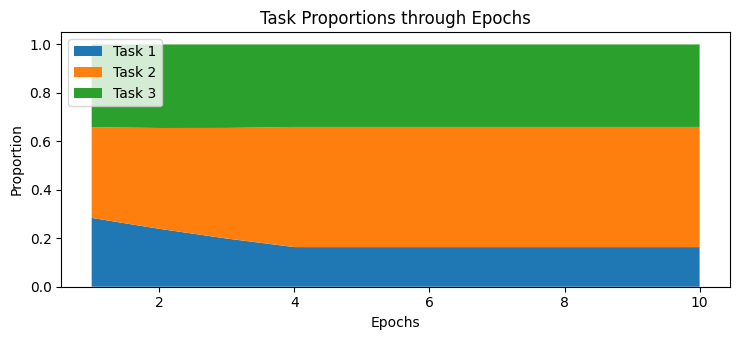

In [25]:
import matplotlib.pyplot as plt

E = 10
Dt = [1000, 4000, 2500]

def alpha_e(e, E, a0=0.2, am=0.8):
    # return 1 - 0.8 * (e - 1) / (E - 1)
    # return 1
    return 1 / min(am, (e - 1) * (am - a0) / len(Dt) + a0)

epochs = np.arange(1, E + 1)
task_proportions = {}
for idx, _ in enumerate(Dt):
    task_proportions[f'Task {idx + 1}'] = []

for e in epochs:
    pt = [d ** (1 / alpha_e(e, E)) for d in Dt]
    pt = [p / sum(pt) for p in pt]
    for idx, p in enumerate(pt):
        task_proportions[f'Task {idx + 1}'].append(p)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True



fig, ax = plt.subplots()
ax.stackplot(epochs, task_proportions.values(), labels=['Task 1', 'Task 2', 'Task 3'])

ax.legend(loc='upper left')
ax.set_title('Task Proportions through Epochs')

ax.set_xlabel('Epochs')
ax.set_ylabel('Proportion')

plt.show()